### 1. Carregando Bibliotecas

In [1]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
#from keras.utils import np_utils
from keras.utils import to_categorical
#from keras.utils import plot_model
from keras.utils import plot_model

import tensorflow as tf

Inicializa o Google Drive. É necessário entrar com as credenciais do Gmail

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Carregando o dataset pré-embaralhado de treinamento bem como os dados de teste

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


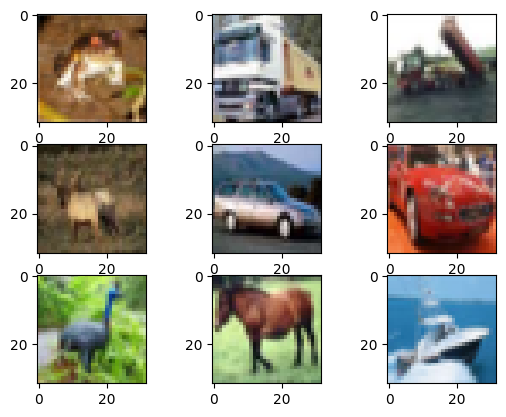

In [4]:
print(f'Train: X={x_train.shape}, y={y_train.shape}')
print(f'Test: X={x_test.shape}, y={y_test.shape}')
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

### 3. Redimensionando as imagens e dividindo cada pixel em cada imagem por 255

In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Dividindo o dataset em treinamento, teste e validação

"One-hot encoding" aplicado aos rótulos


In [6]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
num_classes

10

divindo dataset de treinamento em treinamento, teste e validação - Apenas para exemplo em um ambiente real as amostras devem ser seleciondas de forma aleatória

In [9]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Impressão da forma do conjunto de treino

In [10]:
print('x_train shape:', x_train.shape)

x_train shape: (45000, 32, 32, 3)


In [11]:
print('x_valid shape:', x_valid.shape)

x_valid shape: (5000, 32, 32, 3)


Impressão do número de imagens nos datasets de treinamento, teste e validação

In [12]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


Um pouquinho de novos conceitos.

**Dropout**: Técnica de regularização usada para prevenir o overfitting em redes neurais. Consiste em "desligar" aleatoriamente alguns neurônios durante o treinamento, forçando a rede a não depender excessivamente de características específicas de entrada. Utilize dropout principalmente em redes densas (fully connected) e convolucionais para melhorar a generalização do modelo.

Saiba mais em: [https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/](https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/)

**Batch Normalization**: Método que normaliza as ativações de uma camada para média zero e variância unitária, utilizando estatísticas do mini-lote. Ajuda a acelerar o treinamento e a estabilizar a convergência ao mitigar o problema de deslocamento interno das distribuições das ativações. É útil em praticamente todos os tipos de redes neurais, especialmente em redes profundas, para facilitar um treinamento mais rápido e estável.

Saiba mais em: [https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)


### 5. Definindo a arquitetura do modelo (IMPORTANTE!)


Defina uma rede simples, vou sugerir a seguinte: LeNet-5

*   2 camadas convolucionais de tamanho progressivamente crescente
*   Com "maxpooling" (2x2)
*   Uma camada do tipo totalmente conectada de 120 neurônios
*   Uma camada do tipo totalmente conectada de 84 neurônios
*   Ultimas camadas do tipo totalmente conectadas de 10 saídas (10 classes de categoria de imagem)


*   "Dropout" de 0,2-0,3







In [13]:
## primeira tentativa
model = Sequential()
## CNN
model.add(Conv2D(filters=64, kernel_size=3,  activation='relu', input_shape=(32, 32, 3), padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3,  activation='relu'))
model.add(MaxPooling2D(pool_size=2))

## MLP
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


Tentem executar a rede configurando outras funções de ativação (como visto em nossa Aula 3)
mais informações em https://keras.io/activations/

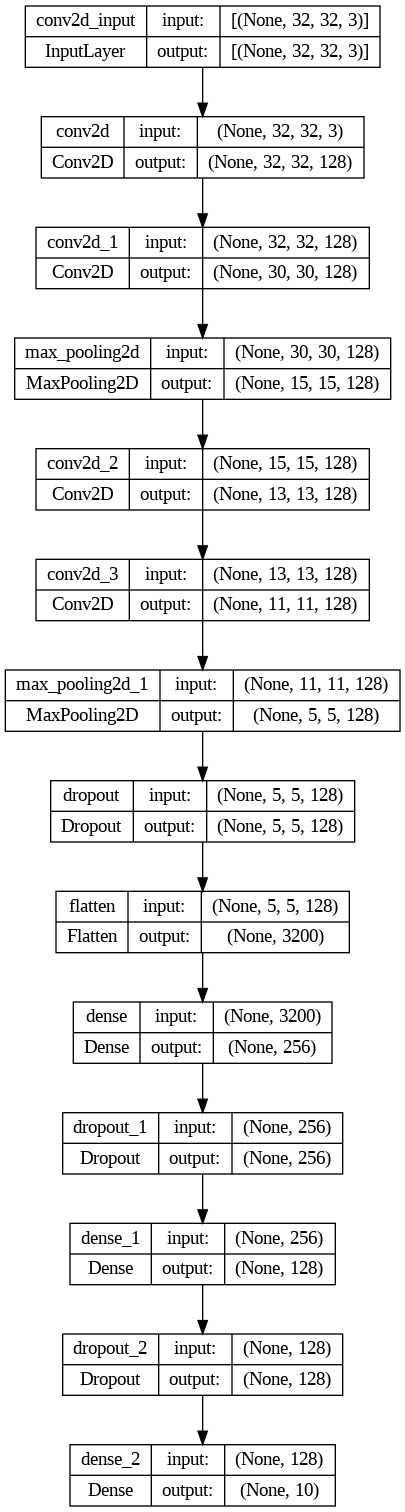

In [14]:
plot_model(model, to_file='cnn-CIFAR10.png', show_shapes=True, show_layer_names=True)

### 6. Compilando o modelo

Compilando o modelo escolhendo como se dará nossa perda, otimização e métricas (parâmetros do Keras)
* mais informações em https://keras.io/losses/
* mais informações em https://keras.io/optimizers/
* mais informações em https://keras.io/metrics/

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 7. Treinando o modelo

In [16]:
from keras.callbacks import ModelCheckpoint

#O keras passa a salvar o melhor modelo pela acurácia de validação

In [17]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/modelocifar.h5', verbose=1,  save_best_only=True, monitor='val_accuracy') #

hist = model.fit(x_train, y_train, batch_size=100, epochs=30, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/30
450/450 [==============================] - ETA: 0s - loss: 1.6596 - accuracy: 0.3873
Epoch 1: val_accuracy improved from -inf to 0.54340, saving model to /content/drive/My Drive/modelocifar.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


450/450 [==============================] - 23s 34ms/step - loss: 1.6596 - accuracy: 0.3873 - val_loss: 1.2678 - val_accuracy: 0.5434
Epoch 2/30
449/450 [============================>.] - ETA: 0s - loss: 1.2054 - accuracy: 0.5708
Epoch 2: val_accuracy improved from 0.54340 to 0.64180, saving model to /content/drive/My Drive/modelocifar.h5
450/450 [==============================] - 15s 33ms/step - loss: 1.2050 - accuracy: 0.5710 - val_loss: 1.0195 - val_accuracy: 0.6418
Epoch 3/30
449/450 [============================>.] - ETA: 0s - loss: 0.9949 - accuracy: 0.6510
Epoch 3: val_accuracy improved from 0.64180 to 0.67520, saving model to /content/drive/My Drive/modelocifar.h5
450/450 [==============================] - 14s 31ms/step - loss: 0.9948 - accuracy: 0.6510 - val_loss: 0.9110 - val_accuracy: 0.6752
Epoch 4/30
449/450 [============================>.] - ETA: 0s - loss: 0.8725 - accuracy: 0.6961
Epoch 4: val_accuracy improved from 0.67520 to 0.71120, saving model to /content/drive/My D

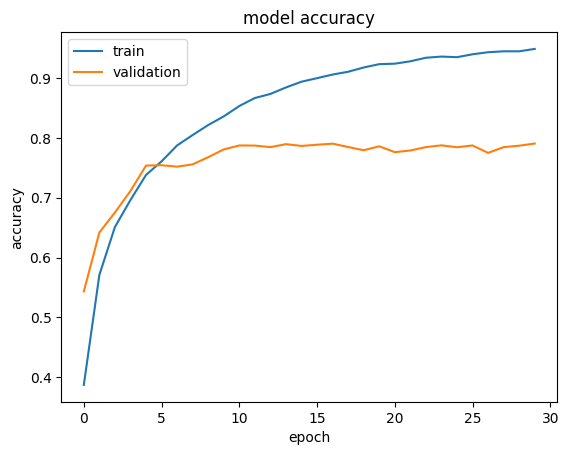

In [18]:
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Carregar o melhor modelo que obteve a melhor acurácia de validação no treinamento

In [19]:
model = load_model("/content/drive/My Drive/modelocifar.h5")

### 8. Cálculo da precisão de classificação no dataset de testes

Avaliar e imprimir a precisão do teste

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7854999899864197


### 9. Visualizar algumas predições

As visualizações podem nos dar algumas dicas sobre por que a rede classifica erroneamente alguns objetos.
Obtendo previsões no conjunto de testes:

In [21]:
y_hat = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [22]:
y_hat[100,:]

array([1.03396337e-06, 3.92779587e-09, 2.90912110e-03, 1.52367875e-05,
       6.07605755e-01, 2.14876439e-02, 6.69553160e-08, 3.67980659e-01,
       3.33775603e-07, 6.63219666e-08], dtype=float32)

In [23]:
np.argmax(y_hat[100,:])

4

Definindo rótulos de texto (rótulos disponíveis na fonte original: https://www.cs.toronto.edu/~kriz/cifar.html)

In [24]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Plot de amostra aleatória de imagens de teste, rótulos preditos e a "ground truth" advinda do dataset CIFAR-10

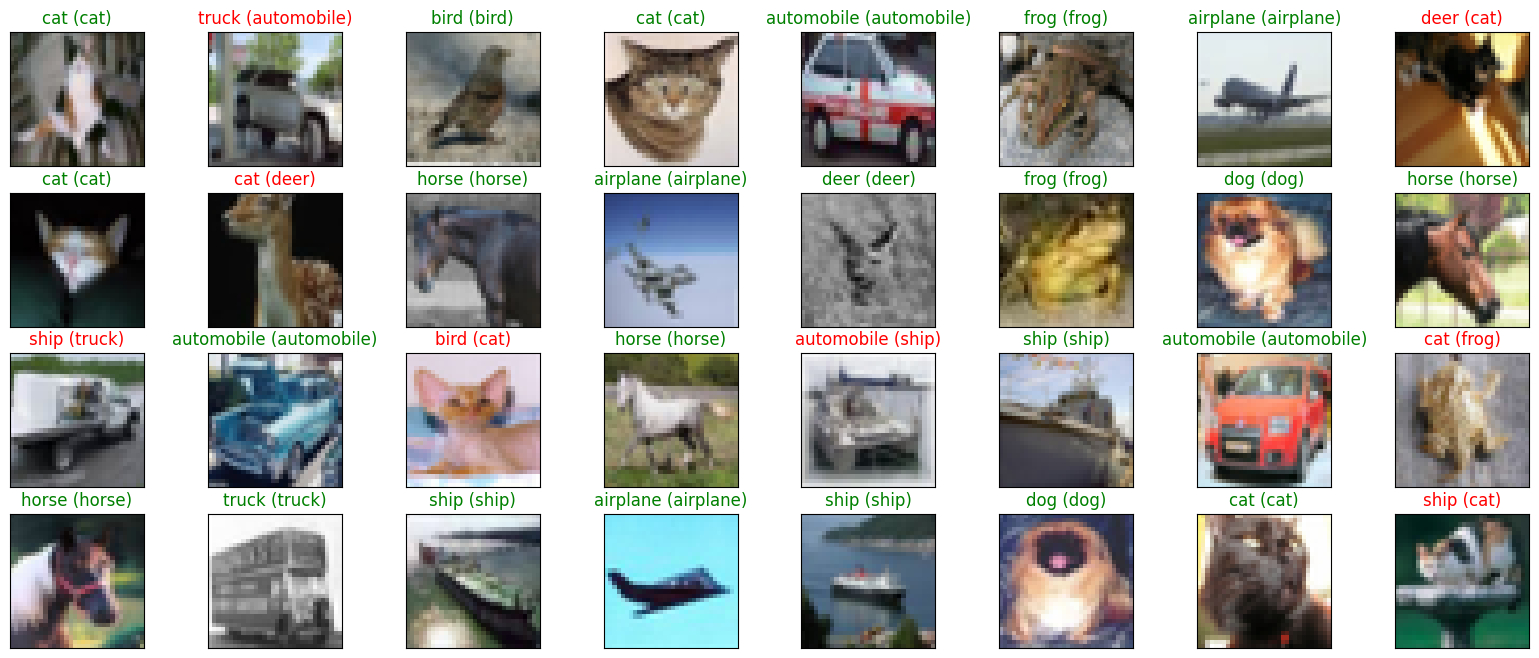

In [25]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    # amostras corretamente classificadas em verde, incorretamente classificadas em vermelho
